# Course lecture
[3 - Performance, Validation and Model Interpretation](http://course18.fast.ai/lessonsml1/lesson3.html)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bogeholm/fastai-intro-to-ml/blob/master/3-performance-validation-and-model-interpretation.ipynb)

# Notes
## Notes from last
- Default settings of Random Forests in `scikit-learn` are very reasonable
- `proc_df()` from `fast.ai` adds a Boolean `isnull` column for *numerical* values, after replacing nulls with the *median*
- There may be values in the test set that weren't in the training set
- The median may differ between the training and test sets
- `proc_df()` changed to return `nas`, a dictionary with names of columns with nulls as keys, and medians as values
- `nas` can be passed as an optional argument to the new `proc_df()`, as well as being returned from it

## Main topic
- Understanding the results of the model - Random Forests are not black boxes

### Predictive confidence
- We don't just want a prediction, we want a confidence of the prediction. Any 'unusual' rows should get low confidence
- If the standard deviation of a row prediction between trees is high, we have low confidence

### Feature importance
- Importance can be used to find out *which features to learn more about*
- If importance goes against expectations, it is worthwhile to investigate. Data problems? New knowledge?
- Maybe a column is only predictive for values that are *missing*? In an example (1:11:45), information about research grant applications - the topic of interest - was only entered into a database *manually* for grant applications *that were accepted*; ie. `null => acceptance=False`. This is **data leakage**. 
- **Colinearity** is another possibility - the variable could be indicative of something else entirely. Ie. `OLED_screen=True` for TV sets would likely indicate a later manufacturing date that `plasma_screen=True` 
- By removing less important variables, you are potentially removing sources of colinearity. This makes the 'true' relationships more clear
- If possible, inspect the variables deeper. Fuzzy variables (eg. `fiModelDesc`); can they be ordered? Can we split the strings?


### Tips on large datasets - side topic
- Large datasets means $\approxeq 10^8$ rows in this particular definition. A specific example is the [Kaggle groceries competition](https://www.kaggle.com/c/favorita-grocery-sales-forecasting), featuring a relational star-schema dataset
- Create a type dict for pandas to use while loading data, to not consume too much RAM for inferring types; eg:
```python
types = {'id': 'int32', 'category':'int8'}
df = pd.read_csv('data.csv', dtype=types)
```
- Use UNIX `shuf` command to get a random sample of the lines in the dataset. Then work as much as possible on the sample before progressing
- Convert as many as possible `object` columns into more primitive types (`bool`s, `int32`s, ...)
- Random subsampling for each tree in a forest with [`set_rf_samples()`](https://github.com/fastai/fastai/blob/c655762c3dc835ea61ad9143d84f1c3b47fe60f4/old/fastai/structured.py#L398) can be useful
- Set `min_samples_leaf=LARGISH_NUMBER` (`100` suggested at 31:00) to save time_resources
- Do not use `oob_score=True` when using `set_rf_samples()` on very large datasets
- RandomForests do not work well on the groceries dataset out of the box
- Hacker tip: take the last two week of data; use store, item, on_promotion average sales - that got into the top 30 on Kaggle!

### Other tips
- Check out `pandas` function `df.describe(include='all')`
- Check out `%prun` for profiling function calls in notebooks
- When working with time series, you will generally have dates **later** in the data set you want to predict, than in the training set. If you want to use a subset of the training set for experimenting, use the **latest** dates possible (*in general*)


## Further notes
- Random Forests are fine for structured data
- For unstructured data (images, speech, ...), try deep learning
- Quality of validation set directly influences quality of model in production
- Plotting "quality" of validation set on the `x`-axis and quality in production on `y`-axis should ideally produce a straight line
- Coding Machine Learning is not technically difficult - but if you get a tiny detail wrong, it means your model ends up worse than it could. If you're not doing eg. Kaggle, there's not a good way to know that. This is an open problem.
- Supplement your model using external data, if possible (historical weather data, oil price, ...).
- Check out [Rossman store sales](https://www.kaggle.com/c/rossmann-store-sales/overview/description) on Kaggle, and [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html). See also the [Kaggle blog](https://medium.com/kaggle-blog)


# Implementation plan
- [ ] Determine *test* vs. *validation* set nomenclature
- [x] Read the data you saved last time
- [x] `min_samples_leaf=3` and `max_features=0.5` turned out fine last time. 
  - [ ] Describe what these settings do
- [x] Inspect the data, looking at relative standard deviation based on categories (`std` / `prediction`)
- [x] Validation set are the last `12_000` values of the test set
- [x] Take 50 trees, and add `std` to a dataFrame copy
- [ ] Compare predictions using all variables, and only the - say - top ten
- [x] Use pandas plotting functions, for the sport of it
- [ ] Plot ordered, barplots, whatever looks good
- [ ] `rf_feat_importance` (from `fast.ai`, based on `scikit-learn`)
- [ ] Move `split_dataset()` to [dataworks](https://github.com/bogeholm/dataworks)
- [ ] Fix the codes returned from `categorize_df()`

## Technique for inspecting feature importance
- Start with base dataset and make a predictive model $m_0$.
- Pick a column, and randomly shuffle it. Compare $R^2$ and RMSE of $m_0$ on the original and shuffled datasets.
- Why not just exclude the column? That would mean training a whole new random forest for each column, which is slow.

## Ideas for improvement
- Look at `train_cats(df)` and `apply_cats(df1, df2)` which are called (in that order) before `proc_df()`
- Keep track of missing values `in proc_df`? Return dict with missing column values, as well as medians, to use on unseen data, or data subsets
- Use all values for training (test set), *last* 12_000 for validation
- Parallelize! (1:00:00) Check out `parallel_trees()` from `fast.ai`

## Install [dataworks](https://github.com/bogeholm/dataworks)

In [1]:
# Uncomment to install dataworks:
#!pip install --upgrade --quiet git+git://github.com/bogeholm/dataworks.git

## Get [notebook utilities file](https://github.com/bogeholm/fastai-intro-to-ml/blob/master/notebookutils.py) - only relevant if in Colab

In [2]:
# Uncomment to fetch notebook utilities
#!curl --proto '=https' --tlsv1.2 -sSf --output notebookutils.py 'https://raw.githubusercontent.com/bogeholm/fastai-intro-to-ml/master/notebookutils.py'

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

#from dataworks.df_utils import (add_datefields, add_nan_columns, categorize_df, inspect_df, 
#    numeric_nans, summarize_df,)

from collections import OrderedDict
from notebookutils import get_basepath, rmse, print_score
from typing import Optional, List, Tuple
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# POandas options
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

# Matplotlib/Jupyter extras and options
from IPython.display import display, set_matplotlib_formats
from IPython.core.pylabtools import figsize

%matplotlib inline
set_matplotlib_formats('png')
# https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 16})

## Mount Google Drive (for [Colab](https://colab.research.google.com/) integration)

In [4]:
BASEPATH = get_basepath()

In [5]:
DATAPATH = os.path.join(*[BASEPATH, 'bulldozers'])
print(f'DATAPATH: {DATAPATH}')

DATAPATH: C:\Users\tbm\Documents\machinelearning\fastai-intro-to-ml\data\bulldozers


### Read dataset

In [6]:
DATASET = os.path.join(*[DATAPATH, 'Train-Preprocessed.zip'])
df_all = pd.read_csv(DATASET, index_col=0)

# The codes are not imediately usefull, since they are saved as text, so we skip importing them for now
# CODESET = os.path.join(*[DATAPATH, 'Train-Codes.zip'])
# df_codes = pd.read_csv(CODESET, index_col=0)

In [7]:
# Let'scheck if we got the log of sale price
'LogSalePrice' in df_all.columns

True

## Notebook utilities

In [8]:
def display_allrows(df):
    """ Override max rows and display them all
    """
    with pd.option_context('display.max_rows', len(df)):
        display(df)

## Split dataset

In [9]:
def split_dataset(df: pd.DataFrame, column: str, indices: Optional[List[bool]]=None, 
                  fromto: Optional[Tuple[int, int]]=None, length: Optional[int]=None) -> Tuple[pd.DataFrame, np.array]:
    """ Split DataFrame into dependent and independent variables. 
        'indices' overrides 'fromto', 'fromto' overrides 'length'
    """
    if indices is not None:
        resdf = df[indices].copy(deep=True)
    elif fromto is not None:
        (low, up) = fromto
        resdf = df[low:up].copy(deep=True)
    elif length is not None:
        resdf = df[0:length].copy(deep=True)
    else:
        resdf = df.copy(deep=True)
    
    # dependent variable
    y_vals = np.array(resdf[column].values)
    # independent variable(s)
    resdf.drop(columns=column, inplace=True)
    
    return resdf, y_vals

In [10]:
len(df_all)
small_dataset = True

n_train = 10_000 if small_dataset else len(df_all) - 12_000
n_valid = 5_000 if small_dataset else 12_000
assert n_train + n_valid <= len(df_all), f'Im sorry, I cannot find {n_train+n_valid} data points'

print(f'n_train: {n_train}')
print(f'n_valid: {n_valid}')

n_train: 10000
n_valid: 5000


In [11]:
X_train, y_train = split_dataset(df_all, 'LogSalePrice', fromto=(0, n_train))
x_valid, y_valid = split_dataset(df_all, 'LogSalePrice', fromto=(n_train, n_train+n_valid))

## Create model

In [12]:
m0 = RandomForestRegressor(min_samples_leaf=3, max_features=0.5, n_estimators=50, n_jobs=-1, oob_score=True)

In [13]:
%time m0.fit(X_train, y_train)

Wall time: 983 ms


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [14]:
print_score(m0, X_train, y_train)

R^2:    0.952
RMSE:   0.153


### Predict LogSalePrice using the individual trees in the model

In [15]:
def predict_treewise(model, X_data):
    """ Predict treewise using model, assumed to be a RandomForestRegressor
        or similar from scikit-learn. Returns mean and standard deviation.
    """
    data_len = np.shape(X_data)[0]
    n_estimators = model.n_estimators

    predictions = np.zeros((data_len, n_estimators))

    for idx, est in enumerate(model.estimators_):
        pred = est.predict(X_data)
        predictions[:, idx] = pred
        
    return np.mean(predictions, axis=1), np.std(predictions, axis=1)

In [16]:
%time pred_mean, pred_std = predict_treewise(m0, X_train)

Wall time: 1.8 s


### Check that the mean of treewise predictions match the model prediction

In [17]:
prediction_diff = pred_mean - m0.predict(X_train)
assert np.allclose(prediction_diff, np.zeros(len(prediction_diff)))

### Bar plots
Tips for plotting:
- [How to calculate mean values grouped on another column in Pandas](https://stackoverflow.com/questions/30482071/how-to-calculate-mean-values-grouped-on-another-column-in-pandas)
- [pandas.DataFrame.plot.bar](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html)

In [18]:
def group_barplot(df, x_col, y_col):
    """ Group DataFrame df by x_col, plot bars with mean of values from y_col
    """
    ax = df.groupby(x_col, as_index=False)[y_col].mean().plot.bar(x=x_col, y=y_col)

In [19]:
df_pred = X_train.copy(deep=True)

In [20]:
df_pred['pred_mean'] = pred_mean
df_pred['pred_std'] = pred_std
# Coefficient of variation 
df_pred['pred_cvar'] = pred_std / pred_mean

### Let's have a look at `Coupler_System`
Below we can see at least two things:
1. The categories are not particularly informative, since we've replaced the original labels with categories. 
2. However, `0` represent a `null` value for category, and it makes intuitive sense that this has the largest coefficient of variation

In [21]:
# df_pred.columns
# np.unique(df_pred.Coupler_System_category)

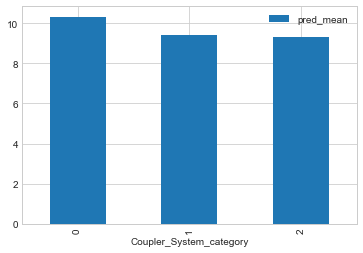

In [22]:
group_barplot(df_pred, 'Coupler_System_category', 'pred_mean')

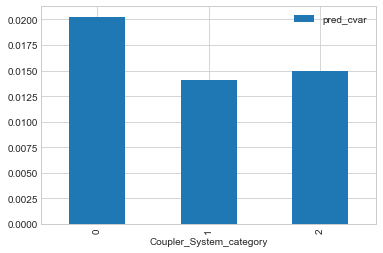

In [23]:
group_barplot(df_pred, 'Coupler_System_category', 'pred_cvar')

## Checking the $R^2$ value for shuffled columns

In [24]:
def shuffle_cols(df):
    """ Return an iterator over df's shuffled columns. 
        Yields shuffled df and colname
    """
    dfc = df.copy(deep=True)
    
    for col in df.columns.values:
        org_col = df[col].values
        shuf_col = np.copy(org_col)
        np.random.shuffle(shuf_col)
        
        dfc[col] = shuf_col
        yield (dfc, col)
        dfc[col] = org_col

In [25]:
def shuffle_predict(model, X_data, y_data):
    """ Shuffle columns of X_data one at a time, and predict with model
    """
    shuffler = shuffle_cols(X_data)
    columns = X_data.columns.values
    n_columns = len(columns)
    
    # Prepare OrderedDict with return values
    resdict = OrderedDict()
    columns = []
    r2_vals = np.zeros(n_columns)
    rmse_vals = np.zeros(n_columns)
    
    for idx, (df_shuffle, colname) in enumerate(shuffler):
        columns.append(colname)
        # Predict with one column shuffled 
        shuffle_predict = model.predict(df_shuffle)
        
        # R squared and RMSE
        r2_vals[idx] = r2_score(shuffle_predict, y_data)
        rmse_vals[idx] = rmse(shuffle_predict, y_data)
    
    resdict['columns'] = columns    
    resdict['r2'] = r2_vals
    resdict['rmse'] = rmse_vals
    
    resdf = pd.DataFrame(resdict)
    resdf.sort_values('r2', ascending=False, inplace=True)
    return resdf
    

In [30]:
%time df_shuf = shuffle_predict(m0, X_train, y_train)

Wall time: 9.42 s


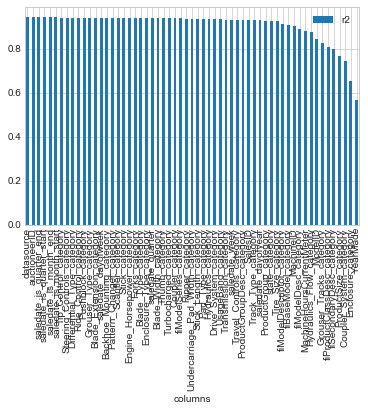

In [31]:
df_shuf.plot.bar(x='columns', y='r2')